To create a model for generating event names based on your database, you'll need to analyze your existing data to identify patterns or features that correlate with successful events. Here's a basic approach:

Data Analysis: Start by analyzing your event data. Look at the names of the most successful events and try to identify common elements. Are there certain keywords, lengths, formats, or styles that are more prevalent in successful event names?

Feature Extraction: Based on your analysis, extract features from these names. This could include the use of specific words, length of the name, use of numbers or special characters, etc.

Model Training: Use these features to train a machine learning model. You might start with simple models like decision trees or logistic regression, and then experiment with more complex models like neural networks if needed.

Keyword Input: For generating new names, your model should take basic keywords or ideas as input. These keywords can be transformed into a feature vector that your model understands.

Name Generation: The output will be a list of suggested names. You might use a generative model like a recurrent neural network (RNN) or a transformer-based model, which can generate text based on the input features.

Evaluation and Iteration: Finally, evaluate the performance of your model. You can start by testing how well the generated names align with your successful event criteria. Iterate and refine your model based on feedback.

What type of events are in your database, and what characteristics typically define their success? This could help in tailoring the model more effectively.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
td = pd.read_csv('transformed_data.csv')
td.head()

,eventId,eventUid,eventName,eventCategory,eventLocation,clubId,clubLogin,clubName,eventAttendees,eventPriceRange,...,parentEventIds,all_results_hidden,hybrid,dayofweek,month,day,year,time,eventDates,hour
0,300368144,a564e3f3f56cb3cc5f952a17116f0353,Tickets for contemporary dance show 'TRAJAL HA...,Off Campus,Centro de Cultura Contemporánea Conde Duque (c...,300002145.0,humanities,IE School of Humanities,12.0,FREE,...,Unknown,NaN,Unknown,Sat,Feb,24.0,2024.0,8 PM – 10 PM,Unknown,20.00
1,300367873,9de91104ee5fb18e4f440bcd9495b02b,Weekly Running Practices,Hybrid,Private Location (register to display),300002813.0,ierunners,IE Runners Club MIX,0.0,FREE,...,Unknown,NaN,Unknown,Sat,Feb,24.0,2024.0,7 PM – 11:30 AM,Unknown,19.00
2,300316787,2a9807915a7dabbc3f65b588649de81c,Saturday Weekly Running Practices,Off Campus,Private Location (register to display),300002813.0,ierunners,IE Runners Club MIX,27.0,FREE,...,Weekly Running Practices,NaN,Unknown,Sat,Feb,24.0,2024.0,10:30 AM – 11:30 AM,Unknown,10.50
3,300368022,7577703fb9dd0624e98b91d46d28cac6,THEATRE REHEARSAL - Act 2 Scene 2,On Campus,"IE TOWER, Piano Lounge",200000032.0,ietheatre,IE Theatre Production,7.0,FREE,...,Unknown,NaN,Unknown,Sat,Feb,24.0,2024.0,10:30 AM – 2 PM,Unknown,10.50
4,300368019,fca36e0ded3f2a8e493b3576ad802587,Hike to Rascafría and Guided Tour of the Monas...,Off Campus,TBD,300002116.0,ieaexp,IExplore,18.0,€12,...,Unknown,NaN,Unknown,Sat,Feb,24.0,2024.0,8:45 AM – 6:30 PM,Unknown,8.75


In [3]:
# 1. Data Analysis
# Extract the 'eventName' column
event_names = td['eventName']

# Split the event names into words and count the occurrence of each word
words = event_names.str.split(expand=True).stack()
word_counts = words.value_counts()

# Print the most common words
print(word_counts.head(10))

-          770
in         491
Open       397
Tuesday    382
IE         373
Office     361
Hours      360
Careers    355
&          332
the        297
dtype: int64


In [4]:
# Analyze the length of the event names
event_names_length = event_names.str.len()
event_names_length.describe()

count    2663.000000
mean       44.547127
std        24.350834
min         4.000000
25%        27.000000
50%        41.000000
75%        52.000000
max       200.000000
Name: eventName, dtype: float64

In [5]:
# 3 iqr of attendees
attendees_iqr = td['eventAttendees'].quantile(0.75) - td['eventAttendees'].quantile(0.25)
min_a, max_a = td['eventAttendees'].quantile(0.25) - 1.5 * attendees_iqr, td['eventAttendees'].quantile(0.75) + 1.5 * attendees_iqr
max_a

105.75

In [6]:
# cluster event attendees into incremental 5 groups
attendees_bins = pd.cut(td['eventAttendees'], bins=range(0, 220, 20))
attendees_bins.value_counts().sort_index()

(0, 20]       1277
(20, 40]       303
(40, 60]       168
(60, 80]       116
(80, 100]       94
(100, 120]      59
(120, 140]      47
(140, 160]      47
(160, 180]      25
(180, 200]      24
Name: eventAttendees, dtype: int64

In [7]:
# create a grade 1-10 based on the clusters:
attendees_grades = pd.cut(td['eventAttendees'], bins=range(0, 220, 20), labels=range(1, 11))
td['attendeesGrades'] = attendees_grades

<AxesSubplot: xlabel='eventName', ylabel='eventAttendees'>

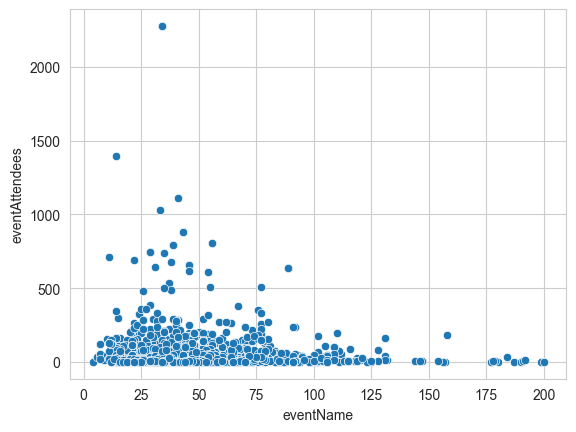

In [8]:
# correlation between event name length and event success (number of attendees) - catter
sns.scatterplot(x=event_names_length, y=td['eventAttendees'])

In [14]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
import re
text_feature_extraction = {
    'length': lambda name: len(name),  # Length of the event name
    'spaces': lambda name: name.count(' '),  # Number of spaces
    'hyphens': lambda name: name.count('-'),  # Number of hyphens
    'word_count': lambda name: len(word_tokenize(name)),  # Number of words
    'longest_word': lambda name: max([len(word) for word in word_tokenize(name)] + [0]),  # Length of the longest word
    'avg_word_length': lambda name: sum([len(word) for word in word_tokenize(name)]) / len(word_tokenize(name)) if word_tokenize(name) else 0,  # Average word length
    'sentence_count': lambda name: len(sent_tokenize(name)),  # Number of sentences
    'digit_count': lambda name: len(re.findall(r'\d', name)),  # Number of digits
    'uppercase_count': lambda name: len(re.findall(r'[A-Z]', name)),  # Number of uppercase letters
    'alphanumeric_count': lambda name: len(re.findall(r'\w+', name)),  # Number of alphanumeric characters
    'special_char_count': lambda name: len(re.findall(r'\W', name)) - name.count(' '),  # Number of special characters (excluding spaces)
    'the_count': lambda name: name.lower().count('the '),  # Occurrences of 'the'
    'and_count': lambda name: name.lower().count('and '),  # Occurrences of 'and'
    'capitalized_word_count': lambda name: sum(map(str.isupper, name)),  # Number of capitalized words
    'unique_word_count': lambda name: len(set(word_tokenize(name.lower()))),  # Number of unique words
    'alphabetic_char_count': lambda name: sum(1 for char in name if char.isalpha()),  # Number of alphabetic characters
    'short_word_count': lambda name: len(re.findall(r'\b\w{1,3}\b', name)),  # Number of short words (1-3 letters)
    # Add more features as needed
}
# Apply the feature functions to the event names
text_feature_extraction.items()

dict_items([('length', <function <lambda> at 0x7796062416c0>), ('spaces', <function <lambda> at 0x779606241d00>), ('hyphens', <function <lambda> at 0x779606242200>), ('word_count', <function <lambda> at 0x779606242f20>), ('longest_word', <function <lambda> at 0x779606243880>), ('avg_word_length', <function <lambda> at 0x779606243380>), ('sentence_count', <function <lambda> at 0x7796062439c0>), ('digit_count', <function <lambda> at 0x779606243560>), ('uppercase_count', <function <lambda> at 0x779606243920>), ('alphanumeric_count', <function <lambda> at 0x779606243b00>), ('special_char_count', <function <lambda> at 0x779606243a60>), ('the_count', <function <lambda> at 0x779606243ec0>), ('and_count', <function <lambda> at 0x779606243ba0>), ('capitalized_word_count', <function <lambda> at 0x779606243e20>), ('unique_word_count', <function <lambda> at 0x779606214220>), ('alphabetic_char_count', <function <lambda> at 0x779606214040>), ('short_word_count', <function <lambda> at 0x7796062142c0>

In [15]:

name_features = event_names.apply(lambda x: pd.Series({name: func(x) for name, func in text_feature_extraction.items()}))
name_features.head()


,length,spaces,hyphens,word_count,longest_word,avg_word_length,sentence_count,digit_count,uppercase_count,alphanumeric_count,special_char_count,the_count,and_count,capitalized_word_count,unique_word_count,alphabetic_char_count,short_word_count
0,120.0,16.0,0.0,19.0,14.0,5.473684,1.0,0.0,58.0,16.0,4.0,0.0,0.0,60.0,18.0,100.0,2.0
1,24.0,2.0,0.0,3.0,9.0,7.333333,1.0,0.0,3.0,3.0,0.0,0.0,0.0,3.0,3.0,22.0,0.0
2,33.0,3.0,0.0,4.0,9.0,7.500000,1.0,0.0,4.0,4.0,0.0,0.0,0.0,4.0,4.0,30.0,0.0
3,33.0,6.0,1.0,7.0,9.0,3.857143,1.0,2.0,18.0,6.0,1.0,0.0,0.0,18.0,6.0,24.0,3.0
4,62.0,10.0,0.0,11.0,10.0,4.727273,1.0,0.0,6.0,11.0,0.0,1.0,1.0,6.0,11.0,52.0,5.0


In [16]:
# turn grade into int
name_features['score'] = td['attendeesGrades']
name_features = name_features.dropna()
# turn score into int
name_features['score'] = name_features['score'].astype(int)
name_features.head()

,length,spaces,hyphens,word_count,longest_word,avg_word_length,sentence_count,digit_count,uppercase_count,alphanumeric_count,special_char_count,the_count,and_count,capitalized_word_count,unique_word_count,alphabetic_char_count,short_word_count,score
0,120.0,16.0,0.0,19.0,14.0,5.473684,1.0,0.0,58.0,16.0,4.0,0.0,0.0,60.0,18.0,100.0,2.0,1
2,33.0,3.0,0.0,4.0,9.0,7.500000,1.0,0.0,4.0,4.0,0.0,0.0,0.0,4.0,4.0,30.0,0.0,2
3,33.0,6.0,1.0,7.0,9.0,3.857143,1.0,2.0,18.0,6.0,1.0,0.0,0.0,18.0,6.0,24.0,3.0,1
4,62.0,10.0,0.0,11.0,10.0,4.727273,1.0,0.0,6.0,11.0,0.0,1.0,1.0,6.0,11.0,52.0,5.0,1
5,22.0,3.0,0.0,4.0,8.0,4.750000,1.0,0.0,19.0,4.0,0.0,0.0,0.0,19.0,4.0,19.0,2.0,2


<AxesSubplot: >

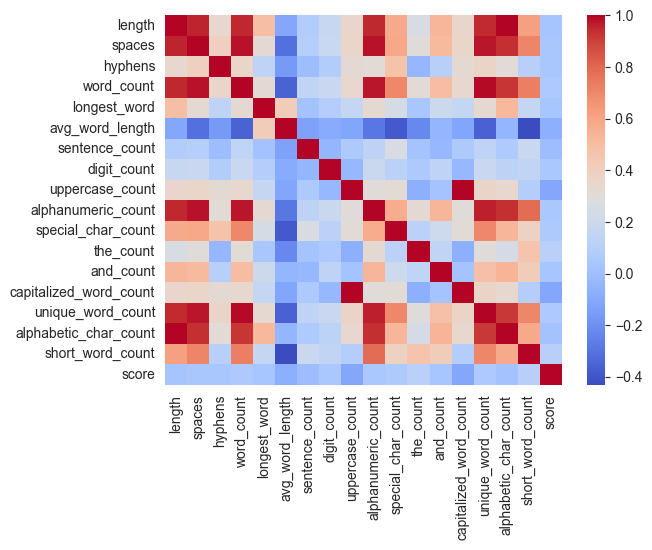

In [18]:
# sns plto corr
sns.heatmap(name_features.corr(), annot=False, cmap='coolwarm')

In [20]:
# corr with score, top 5
name_features.corr()['score'].sort_values(ascending=False).head(5)[1:]

the_count             0.115660
short_word_count      0.104319
special_char_count    0.061340
word_count            0.059566
Name: score, dtype: float64

In [27]:
!pip install textblob

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.3/626.3 kB 9.1 MB/s eta 0:00:00a 0:00:01


In [29]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
import numpy as np
from textblob import TextBlob
from spacy.lang.en

import en_core_web_sm

processed_data = td[['eventName']].dropna()
nlp = en_core_web_sm.load()

# 1. Topic Modeling with LDA
n_topics = 5
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(processed_data['eventName'])
lda = LatentDirichletAllocation(n_components=n_topics, random_state=0)
lda.fit(tfidf)

print(lda.components_)

# Extracting topics and their word distributions
topics = {i: [tfidf_vectorizer.get_feature_names_out()[index] for index in topic.argsort()[:-10 - 1:-1]]
          for i, topic in enumerate(lda.components_)}

# 2. Sentiment Analysis
from textblob import TextBlob

# Calculating sentiment for each event name
sentiments = processed_data['eventName'].apply(lambda x: TextBlob(x).sentiment.polarity)

# 3. Named Entity Recognition
# Extracting named entities from event names
entities = []
for doc in nlp.pipe(processed_data['eventName']):
    entities.extend([ent.text for ent in doc.ents])

# 4. Text Complexity Analysis
# Calculating average word length as a proxy for complexity
avg_word_length = processed_data['eventName'].apply(lambda x: np.mean([len(word) for word in x.split()]) if x.split() else 0)

# Preparing data for visualizations and further analysis
topic_data = pd.DataFrame(topics).T.reset_index().rename(columns={"index": "Topic"})
sentiment_data = pd.DataFrame({'eventName': processed_data['eventName'], 'sentiment': sentiments})
entity_data = pd.Series(entities).value_counts().reset_index().rename(columns={"index": "Entity", 0: "Count"})
complexity_data = pd.DataFrame({'eventName': processed_data['eventName'], 'avg_word_length': avg_word_length})

topic_data, sentiment_data.head(), entity_data.head(), complexity_data.head()

/home/velocitatem/.local/lib/python3.11/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.7.1) was trained with spaCy v3.7.2 and may not be 100% compatible with the current version (3.7.0). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


[[2.38572422 0.20001065 0.20001875 ... 0.20006263 0.20001425 1.01515862]
 [0.20005392 1.65557481 0.20083153 ... 0.20002191 0.20001469 0.2000245 ]
 [0.20003875 0.20000828 0.20024706 ... 0.8767071  0.20001036 0.2000142 ]
 [0.20567047 0.20001384 0.20002775 ... 0.20003357 1.11137692 0.20133621]
 [1.14802603 0.2000118  1.64769003 ... 0.20001996 0.20001483 0.20002075]]


(   Topic         0        1             2         3           4         5  \
 0      0   segovia    women           men       law  basketball   tryouts   
 1      1    career       cv  optimization      club  wednesdays  practice   
 2      2   tuesday     open        office     hours     careers    social   
 3      3      meet   career     interview      prep          hr    expert   
 4      4  swimming  segovia          case  practice      weekly        ai   
 
             6        7         8          9  
 0      madrid       vs   classes       club  
 1    football  venture   session        fun  
 2  consulting  finance      tech  marketing  
 3      campus    crack  practice      night  
 4     running   series    luxury   consumer  ,
                                            eventName  sentiment
 0  Tickets for contemporary dance show 'TRAJAL HA...   0.166667
 1                           Weekly Running Practices   0.000000
 2                  Saturday Weekly Running Practice

In [30]:
topic_data

,Topic,0,1,2,3,4,5,6,7,8,9
0,0,segovia,women,men,law,basketball,tryouts,madrid,vs,classes,club
1,1,career,cv,optimization,club,wednesdays,practice,football,venture,session,fun
2,2,tuesday,open,office,hours,careers,social,consulting,finance,tech,marketing
3,3,meet,career,interview,prep,hr,expert,campus,crack,practice,night
4,4,swimming,segovia,case,practice,weekly,ai,running,series,luxury,consumer


In [31]:
sentiment_data

,eventName,sentiment
0,Tickets for contemporary dance show 'TRAJAL HA...,0.166667
1,Weekly Running Practices,0.000000
2,Saturday Weekly Running Practices,0.000000
3,THEATRE REHEARSAL - Act 2 Scene 2,0.000000
4,Hike to Rascafría and Guided Tour of the Monas...,0.000000
...,...,...
2658,IE International Career Days - INDIA,0.000000
2659,IE Summer Diplomas & Certificates 2023 - Infor...,0.000000
2660,EDEN FUND - Apply Now!,0.000000
2661,Career Practice: Interview Prep with HR Expert,0.000000


In [32]:
entity_data

,Entity,Count
0,Tuesday,382
1,Career Practice,75
2,Segovia,75
3,CV Optimization,50
4,IE FUN,49
...,...,...
1274,Alumni Networking Nights,1
1275,Edición de Derecho,1
1276,Venture Network Future of Mobility: Drive to T...,1
1277,Descubre el Poder de la Inteligencia Artificial,1


In [33]:
complexity_data

,eventName,avg_word_length
0,Tickets for contemporary dance show 'TRAJAL HA...,6.117647
1,Weekly Running Practices,7.333333
2,Saturday Weekly Running Practices,7.500000
3,THEATRE REHEARSAL - Act 2 Scene 2,3.857143
4,Hike to Rascafría and Guided Tour of the Monas...,4.727273
...,...,...
2658,IE International Career Days - INDIA,5.166667
2659,IE Summer Diplomas & Certificates 2023 - Infor...,5.777778
2660,EDEN FUND - Apply Now!,3.600000
2661,Career Practice: Interview Prep with HR Expert,5.714286


In [ ]:
name_features = name_features.join(sentiment_data['sentiment'])

In [46]:
name_features.head()

,length,spaces,hyphens,word_count,longest_word,avg_word_length,sentence_count,digit_count,uppercase_count,alphanumeric_count,special_char_count,the_count,and_count,capitalized_word_count,unique_word_count,alphabetic_char_count,short_word_count,score,sentiment
0,120.0,16.0,0.0,19.0,14.0,5.473684,1.0,0.0,58.0,16.0,4.0,0.0,0.0,60.0,18.0,100.0,2.0,1,0.166667
2,33.0,3.0,0.0,4.0,9.0,7.500000,1.0,0.0,4.0,4.0,0.0,0.0,0.0,4.0,4.0,30.0,0.0,2,0.000000
2,33.0,3.0,0.0,4.0,9.0,7.500000,1.0,0.0,4.0,4.0,0.0,0.0,0.0,4.0,4.0,30.0,0.0,2,0.000000
2,33.0,3.0,0.0,4.0,9.0,7.500000,1.0,0.0,4.0,4.0,0.0,0.0,0.0,4.0,4.0,30.0,0.0,2,0.000000
2,33.0,3.0,0.0,4.0,9.0,7.500000,1.0,0.0,4.0,4.0,0.0,0.0,0.0,4.0,4.0,30.0,0.0,2,0.000000


In [49]:
# corr sentiment and score
np.corrcoef(name_features['sentiment'], name_features['score'])

array([[1.        , 0.11063499],
       [0.11063499, 1.        ]])

In [47]:
# corre word length and sentiment log tranform each
# drop 0s in temp vars
t1 = complexity_data['avg_word_length']
t2 = sentiment_data['sentiment']
# drop 0s and make sure they are the same length
t1 = t1[t1 != 0]
t2 = t2[t2 != 0]
t1 = t1[:len(t2)]
t2 = t2[:len(t1)]
# plot and print corr
print(np.corrcoef(t1, t2))
sns.scatterplot(x=t1, y=t2)

[[1.        0.0128879]
 [0.0128879 1.       ]]


/home/velocitatem/.local/lib/python3.11/site-packages/seaborn/_oldcore.py:962: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  plot_data = pd.DataFrame(plot_data)


ValueError: cannot reindex on an axis with duplicate labels

In [ ]:
# 2. Feature Extraction
